In [132]:
# standard imports
import os
import datetime
from pathlib import Path
from collections import defaultdict
import scipy
import random
import numpy as np
#import xarray as xr
import pandas as pd
import joblib
import pickle
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [133]:
# machine learning libraries
import sklearn            # machine-learning libary with many algorithms implemented
import xgboost as xgb     # extreme gradient boosting (XGB
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, max_error, mean_squared_error, mean_absolute_error, median_absolute_error

In [134]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [135]:
# shape library
import shap

In [136]:
# print the JS visualization code to the notebook
shap.initjs()

In [143]:
os.getcwd()

'/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/Modeling'

In [137]:
train_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/train.csv')
test_df = pd.read_csv('/Users/tomislav_galjanic/Documents/Tomislav/Columbia/Courses/Fall 2021/ENGI E4800/Tedesco/SEPHER 2.0/Model Files/test.csv')

### Transform AFAM, WHITE, and HISPANIC to proportion of total population

In [144]:
def per_pop(population, feature):
    if population > 0:
        return feature/population
    else:
        return np.nan

In [146]:
train_df['AFAM'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
train_df['WHITE'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
train_df['HISPANIC'] = train_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [147]:
train_df.describe()

EP_UNEMP         EP_PCI        EP_POV      EP_NOVEH     EP_NOHSDP  \
count  11892.000000   11907.000000  11884.000000  11878.000000  11911.000000   
mean       7.951892   28557.180986     16.459635      9.359151     12.745294   
std        5.538075   13485.964541     12.734019     11.922755      9.427160   
min        0.000000     238.000000      0.000000      0.000000      0.000000   
25%        4.300000   19966.000000      7.200000      2.500000      5.700000   
50%        6.500000   25738.000000     13.100000      5.400000     10.400000   
75%       10.000000   33788.000000     22.200000     11.000000     17.600000   
max       59.300000  140255.000000    100.000000    100.000000     66.900000   

          EP_MOBILE     EP_MINRTY      EP_CROWD      EP_AGE65      EP_AGE17  \
count  11881.000000  11989.000000  11989.000000  11912.000000  11989.000000   
mean       6.583116     32.903637      2.497798     15.466429     22.105030   
std       11.411780     27.998938      3.490491      7.688546      6.699485   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      9.700000      0.400000     10.500000     18.700000   
50%        0.800000     23.900000      1.400000     14.900000     22.400000   
75%        8.300000     50.200000      3.300000     19.000000     26.000000   
max      100.000000    100.000000    100.000000    100.000000     53.600000   

               AFAM         WHITE      HISPANIC     WFIR_EALT     HRCN_EALT  \
count  11913.000000  11913.000000  11913.000000  1.197000e+04  1.197000e+04   
mean       0.003627      0.033783      0.003090  1.103440e+04  5.523984e+04   
std        0.005943      0.023885      0.004995  7.876982e+04  2.810936e+05   
min        0.000000      0.000000      0.000000  0.000000e+00  0.000000e+00   
25%        0.000276      0.017846      0.000442  0.000000e+00  9.068292e+02   
50%        0.001261      0.031827      0.001346  0.000000e+00  6.321705e+03   
75%        0.004480      0.045717      0.003630  3.766287e+02  2.643580e+04   
max        0.099834      0.500000      0.131356  3.834543e+06  1.275826e+07   

          CFLD_EALT     RFLD_EALT      HWAV_EALT    POPULATION     EVICTIONS  
count  1.197000e+04  1.197000e+04   11970.000000  12023.000000  12031.000000  
mean   9.146757e+03  4.516798e+04   10727.760808   4261.110538     21.565955  
std    2.654361e+05  1.376434e+05   40566.201157   2167.705352     30.862419  
min    0.000000e+00  0.000000e+00       0.000000      0.000000      0.000000  
25%    0.000000e+00  1.373032e+03     101.938150   2852.000000      3.000000  
50%    0.000000e+00  1.141616e+04    2766.609000   4001.000000     10.000000  
75%    4.553447e-01  3.955105e+04    8594.364750   5346.500000     26.000000  
max    2.792418e+07  6.814114e+06  745717.500000  53812.000000    385.000000

In [148]:
test_df['AFAM'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['AFAM']), axis=1)
test_df['WHITE'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['WHITE']), axis=1)
test_df['HISPANIC'] = test_df.apply(lambda x: per_pop(x['POPULATION'], x['HISPANIC']), axis=1)

In [150]:
test_df.describe()

EP_UNEMP         EP_PCI       EP_POV     EP_NOVEH    EP_NOHSDP  \
count  2973.000000    2976.000000  2972.000000  2971.000000  2977.000000   
mean      8.067037   28391.974126    16.993102     9.880781    12.979342   
std       5.533451   13515.934969    12.935581    12.950432     9.808189   
min       0.000000       6.000000     0.000000     0.000000     0.000000   
25%       4.400000   19736.250000     7.300000     2.650000     5.700000   
50%       6.600000   25543.500000    13.600000     5.500000    10.500000   
75%      10.000000   33482.250000    23.425000    11.450000    18.000000   
max      43.800000  139678.000000   100.000000   100.000000   100.000000   

         EP_MOBILE    EP_MINRTY     EP_CROWD     EP_AGE65     EP_AGE17  \
count  2972.000000  2996.000000  2996.000000  2977.000000  2996.000000   
mean      6.413190    33.215454     2.549599    15.430131    22.030207   
std      11.392921    28.191928     3.892751     7.983248     6.838481   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000    10.100000     0.400000    10.500000    18.600000   
50%       0.700000    23.700000     1.400000    14.700000    22.400000   
75%       8.100000    50.575000     3.200000    18.900000    26.000000   
max     100.000000   100.000000   100.000000   100.000000    53.900000   

              AFAM        WHITE     HISPANIC     WFIR_EALT     HRCN_EALT  \
count  2978.000000  2978.000000  2978.000000  2.993000e+03  2.994000e+03   
mean      0.003493     0.033207     0.002923  1.067906e+04  5.500844e+04   
std       0.005713     0.024775     0.004993  7.177894e+04  2.747155e+05   
min       0.000000     0.000000     0.000000  0.000000e+00  0.000000e+00   
25%       0.000282     0.016945     0.000443  0.000000e+00  9.258444e+02   
50%       0.001229     0.030951     0.001264  0.000000e+00  5.552359e+03   
75%       0.004228     0.044948     0.003409  3.431575e+02  2.670756e+04   
max       0.078618     0.380682     0.111111  1.756496e+06  7.605758e+06   

          CFLD_EALT     RFLD_EALT      HWAV_EALT    POPULATION    EVICTIONS  
count  2.994000e+03  2.994000e+03    2994.000000   3008.000000  3008.000000  
mean   1.069648e+04  4.051387e+04   11852.264114   4293.026596    22.280585  
std    2.001914e+05  1.106341e+05   41269.113960   2103.466846    31.516842  
min    0.000000e+00  0.000000e+00       0.000000      0.000000     0.000000  
25%    0.000000e+00  1.280739e+03     151.495800   2859.500000     4.000000  
50%    0.000000e+00  1.122709e+04    2989.905000   4066.000000    11.000000  
75%    2.572031e-01  3.965665e+04    9355.120000   5432.000000    27.000000  
max    9.289928e+06  3.477010e+06  799145.000000  28926.000000   277.000000

In [151]:
XY_var = list(train_df.columns)
XY_var.pop(0)
XY_var

['EP_UNEMP',
 'EP_PCI',
 'EP_POV',
 'EP_NOVEH',
 'EP_NOHSDP',
 'EP_MOBILE',
 'EP_MINRTY',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_EALT',
 'HRCN_EALT',
 'CFLD_EALT',
 'RFLD_EALT',
 'HWAV_EALT',
 'POPULATION',
 'EVICTIONS']

In [152]:
corr_train = train_df[XY_var].corr()
corr_train_df = pd.DataFrame(corr_train, index=XY_var, columns=XY_var)

<Axes:title={'center':'Training data corrrelation'}>

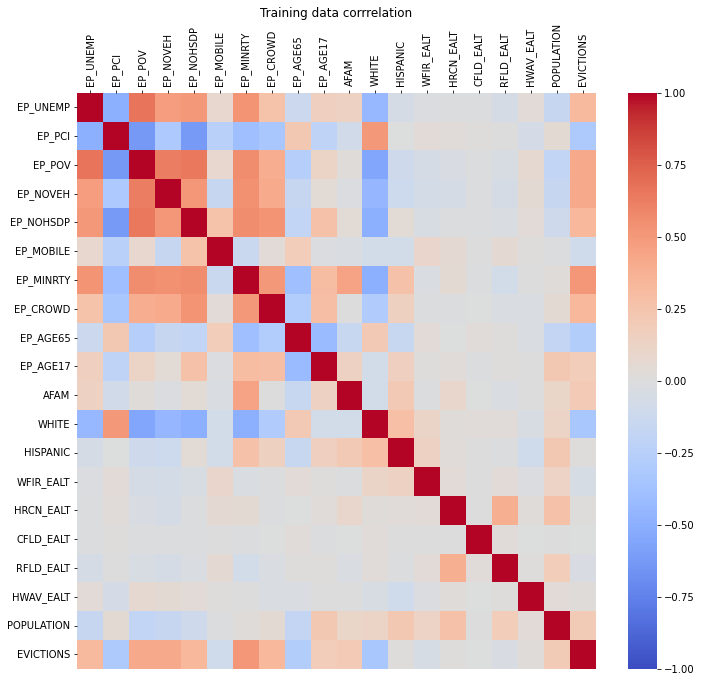

In [153]:
fig = plt.figure(figsize = (9,8))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_ticks_position("top")
plt.title("Training data corrrelation")
sns.heatmap(corr_train_df, center = 0, vmin=-1, vmax=1, cmap = 'coolwarm')

In [154]:
corr_train

EP_UNEMP    EP_PCI    EP_POV  EP_NOVEH  EP_NOHSDP  EP_MOBILE  \
EP_UNEMP    1.000000 -0.494504  0.667656  0.480295   0.505420   0.081013   
EP_PCI     -0.494504  1.000000 -0.627638 -0.315351  -0.624941  -0.242241   
EP_POV      0.667656 -0.627638  1.000000  0.625888   0.650145   0.081327   
EP_NOVEH    0.480295 -0.315351  0.625888  1.000000   0.509378  -0.157552   
EP_NOHSDP   0.505420 -0.624941  0.650145  0.509378   1.000000   0.258484   
EP_MOBILE   0.081013 -0.242241  0.081327 -0.157552   0.258484   1.000000   
EP_MINRTY   0.523932 -0.395673  0.557239  0.545769   0.561454  -0.135218   
EP_CROWD    0.260525 -0.339120  0.391731  0.412020   0.530635   0.031791   
EP_AGE65   -0.131219  0.226022 -0.261701 -0.157763  -0.185375   0.184242   
EP_AGE17    0.158638 -0.204797  0.123653  0.041187   0.268560  -0.019484   
AFAM        0.137845 -0.091611  0.022880 -0.018980   0.044132  -0.029871   
WHITE      -0.442633  0.502674 -0.558273 -0.449826  -0.505274  -0.080464   
HISPANIC   -0.060405 -0.003104 -0.103589 -0.114913   0.044502  -0.080243   
WFIR_EALT  -0.018336  0.034621 -0.056395 -0.071086  -0.042463   0.094255   
HRCN_EALT  -0.010311  0.025014 -0.032605 -0.061687  -0.013777   0.061023   
CFLD_EALT  -0.008206  0.011444 -0.010163 -0.008352  -0.013602   0.006817   
RFLD_EALT  -0.058246  0.004043 -0.042605 -0.060666  -0.023623   0.059281   
HWAV_EALT   0.036648 -0.065184  0.064817  0.051631   0.038302   0.012882   
POPULATION -0.159476  0.053508 -0.187447 -0.163215  -0.107469  -0.009269   
EVICTIONS   0.315931 -0.310825  0.415983  0.417118   0.330778  -0.101365   

            EP_MINRTY  EP_CROWD  EP_AGE65  EP_AGE17      AFAM     WHITE  \
EP_UNEMP     0.523932  0.260525 -0.131219  0.158638  0.137845 -0.442633   
EP_PCI      -0.395673 -0.339120  0.226022 -0.204797 -0.091611  0.502674   
EP_POV       0.557239  0.391731 -0.261701  0.123653  0.022880 -0.558273   
EP_NOVEH     0.545769  0.412020 -0.157763  0.041187 -0.018980 -0.449826   
EP_NOHSDP    0.561454  0.530635 -0.185375  0.268560  0.044132 -0.505274   
EP_MOBILE   -0.135218  0.031791  0.184242 -0.019484 -0.029871 -0.080464   
EP_MINRTY    1.000000  0.500723 -0.393476  0.300892  0.448679 -0.495516   
EP_CROWD     0.500723  1.000000 -0.284238  0.292757  0.002116 -0.295063   
EP_AGE65    -0.393476 -0.284238  1.000000 -0.423751 -0.150188  0.217097   
EP_AGE17     0.300892  0.292757 -0.423751  1.000000  0.146463 -0.084231   
AFAM         0.448679  0.002116 -0.150188  0.146463  1.000000 -0.079873   
WHITE       -0.495516 -0.295063  0.217097 -0.084231 -0.079873  1.000000   
HISPANIC     0.271573  0.151971 -0.150216  0.159874  0.214894  0.282341   
WFIR_EALT   -0.027560 -0.012254  0.036954  0.010311 -0.013258  0.111765   
HRCN_EALT    0.047033 -0.014374 -0.002466  0.023484  0.093697  0.015740   
CFLD_EALT   -0.014147 -0.003216  0.024472 -0.015129 -0.007803  0.030614   
RFLD_EALT   -0.079338 -0.028798  0.014574  0.013880 -0.024061  0.029792   
HWAV_EALT    0.006962 -0.024098 -0.027214  0.004837  0.003714 -0.043388   
POPULATION   0.016362  0.048259 -0.176225  0.225465  0.108224  0.119429   
EVICTIONS    0.508257  0.331773 -0.277880  0.183277  0.206230 -0.336033   

            HISPANIC  WFIR_EALT  HRCN_EALT  CFLD_EALT  RFLD_EALT  HWAV_EALT  \
EP_UNEMP   -0.060405  -0.018336  -0.010311  -0.008206  -0.058246   0.036648   
EP_PCI     -0.003104   0.034621   0.025014   0.011444   0.004043  -0.065184   
EP_POV     -0.103589  -0.056395  -0.032605  -0.010163  -0.042605   0.064817   
EP_NOVEH   -0.114913  -0.071086  -0.061687  -0.008352  -0.060666   0.051631   
EP_NOHSDP   0.044502  -0.042463  -0.013777  -0.013602  -0.023623   0.038302   
EP_MOBILE  -0.080243   0.094255   0.061023   0.006817   0.059281   0.012882   
EP_MINRTY   0.271573  -0.027560   0.047033  -0.014147  -0.079338   0.006962   
EP_CROWD    0.151971  -0.012254  -0.014374  -0.003216  -0.028798  -0.024098   
EP_AGE65   -0.150216   0.036954  -0.002466   0.024472   0.014574  -0.027214   
EP_AGE17    0.159874   0.010311   0.023484  -0.01

### Examine multicollinearity between features using Variance Inflation Factor

In [156]:
X_var = copy.deepcopy(XY_var)
X_var.remove('EVICTIONS')
temp = train_df[X_var]
sel = ~temp.isna().any(axis=1)
temp = temp.loc[sel,]
temp_cols = pd.Index(['const'])
temp_cols = temp_cols.append(temp.columns)

In [160]:
vifs = pd.Series([variance_inflation_factor(sm.add_constant(temp).values, i) 
               for i in range(temp.shape[1]+1)], 
              index=temp_cols).sort_values(ascending=False)
vifs

const         65.900517
EP_MINRTY      4.431170
EP_POV         3.426923
EP_NOHSDP      2.996172
EP_NOVEH       2.324711
EP_PCI         2.223614
WHITE          2.208801
EP_UNEMP       2.084171
EP_CROWD       1.715456
HISPANIC       1.693855
AFAM           1.639003
EP_AGE65       1.564665
EP_AGE17       1.458151
EP_MOBILE      1.432037
POPULATION     1.289200
HRCN_EALT      1.278230
RFLD_EALT      1.210088
WFIR_EALT      1.055368
HWAV_EALT      1.023901
CFLD_EALT      1.002568
dtype: float64

### Final  feature selection and data prep

In [161]:
X_var = ['EP_UNEMP',
 'EP_PCI',
 'EP_NOVEH',
 'EP_MOBILE',
 'EP_CROWD',
 'EP_AGE65',
 'EP_AGE17',
 'AFAM',
 'WHITE',
 'HISPANIC',
 'WFIR_EALT',
 'HRCN_EALT',
 'CFLD_EALT',
 'RFLD_EALT',
 'HWAV_EALT',
 'POPULATION']
Y_var = ['EVICTIONS']

In [163]:
train_sel = ~train_df[Y_var].isna().any(axis=1)
#train_sel = ~train_df[X_var+Y_var].isna().any(axis=1)
sum(train_sel)

12031

In [164]:
#X_train = train_df.loc[train_sel,X_var].to_numpy()
#y_train = train_df.loc[train_sel,Y_var].to_numpy().ravel()
X_train = train_df.loc[train_sel,X_var]
y_train = train_df.loc[train_sel,Y_var]

In [165]:
test_sel = ~test_df[Y_var].isna().any(axis=1)
#test_sel = ~test_df[X_var+Y_var].isna().any(axis=1)
sum(test_sel)

3008

In [166]:
#X_test = test_df.loc[test_sel,X_var].to_numpy()
#y_test = test_df.loc[test_sel,Y_var].to_numpy().ravel()
X_test = test_df.loc[test_sel,X_var]
y_test = test_df.loc[test_sel,Y_var]

## XGBoost Model Specification

In [170]:
# Parameter grids
xg_param_grid = {"n_estimators":[50, 100, 250, 500],
                 "max_depth":[3,4,5,6]
                }

In [171]:
kf = KFold(n_splits=5).split(X_train,y_train)
xg_model = XGBRegressor(random_state=123)
grid = GridSearchCV(xg_model, xg_param_grid, scoring='neg_mean_squared_error', cv=kf, return_train_score=False, refit=True)

In [172]:
print(datetime.datetime.now())

grid.fit(X_train,y_train)
best_params = grid.best_params_
print(best_params)

print(datetime.datetime.now())

2021-11-26 20:09:22.874842
{'max_depth': 5, 'n_estimators': 100}
2021-11-26 20:11:53.959536


In [173]:
# Fit the model on train data using optimal hyperparameters 
xg_model = XGBRegressor(random_state=123, **best_params)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## XGBoost Model evaluation

In [174]:
def evaluate_predict(y, pred):
    scores = {
        'mse':mean_squared_error(y, pred),
        'rmse':np.sqrt(mean_squared_error(y, pred)),
        'mae':mean_absolute_error(y, pred),
        'medae':median_absolute_error(y, pred),
        'max_error':max_error(y, pred),
        'bias':pred.mean() - y.mean(),
        'r2':r2_score(y, pred),
        'corr':np.corrcoef(y,pred)[0,1],
        }
    return scores

### Train data metrics

In [175]:
# Calculate test data error metrics
y_pred_train = xg_model.predict(X_train)

resid_train = y_train['EVICTIONS'].values - y_pred_train
df_results_train = pd.DataFrame({'y_train':y_train['EVICTIONS'].values, 'y_pred_train': y_pred_train, 'resid_train': resid_train})

In [176]:
train_scores = evaluate_predict(y_train['EVICTIONS'].values, y_pred_train)
train_scores

{'mse': 139.3143165967929,
 'rmse': 11.803148588270544,
 'mae': 7.675751288879953,
 'medae': 4.949913024902344,
 'max_error': 102.99894714355469,
 'bias': -0.003990582204618676,
 'r2': 0.8537243869152885,
 'corr': 0.9266083400202331}

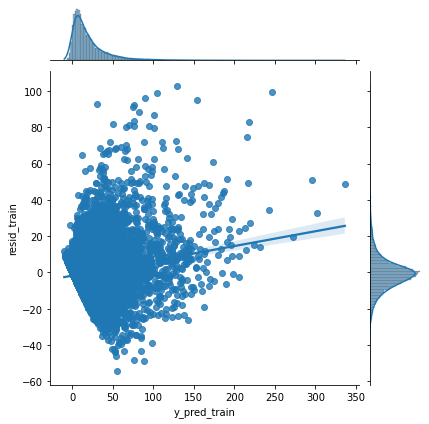

In [177]:
sns.jointplot(x = 'y_pred_train', y = 'resid_train', data = df_results_train, kind = 'reg')

### Test data metrics

In [178]:
# Calculate test data error metrics
y_pred_test = xg_model.predict(X_test)

resid_test = y_test['EVICTIONS'].values - y_pred_test
df_results = pd.DataFrame({'y_test':y_test['EVICTIONS'].values, 'y_pred_test': y_pred_test, 'resid_test': resid_test})

In [179]:
test_scores = evaluate_predict(y_test['EVICTIONS'].values, y_pred_test)
test_scores

{'mse': 447.54689692159525,
 'rmse': 21.155304226637707,
 'mae': 12.438353547996698,
 'medae': 6.668177500367165,
 'max_error': 216.47334671020508,
 'bias': 0.18232840680061457,
 'r2': 0.5492896175746487,
 'corr': 0.7433347918953104}

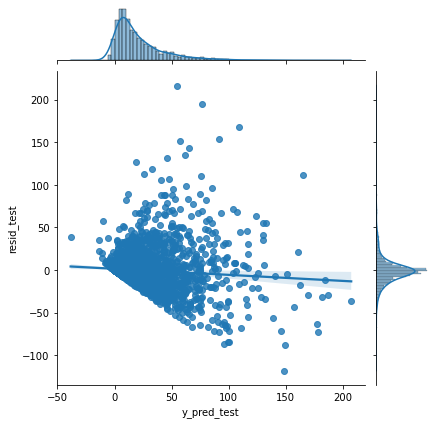

In [180]:
sns.jointplot(x = 'y_pred_test', y = 'resid_test', data = df_results, kind = 'reg')

[Text(0.5, 0, 'y_test predicted'),
 Text(0, 0.5, 'count'),
 Text(0.5, 1.0, 'Histogram of y_test predicted'),
 (0.0, 1500.0)]

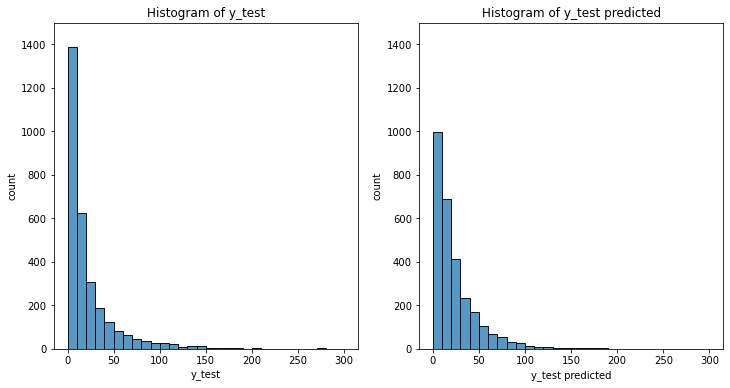

In [181]:
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
sns.histplot(y_pred_test, kde=False,  binwidth = 10, binrange = (0,300), ax = ax[1])
sns.histplot(y_test['EVICTIONS'], kde=False, binwidth = 10, binrange = (0,300), ax = ax[0])

ax[0].set(xlabel='y_test', ylabel='count', title='Histogram of y_test', ylim=[0,1500])
ax[1].set(xlabel='y_test predicted', ylabel='count', title='Histogram of y_test predicted', ylim=[0,1500])

## Feature importance

In [182]:
# explain the model's predictions using SHAP
t_explainer = shap.TreeExplainer(xg_model)
t_shap_values = t_explainer(X_test)
shap_values = t_explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [201]:
# visualize all the training set predictions
shap.plots.force(t_shap_values)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


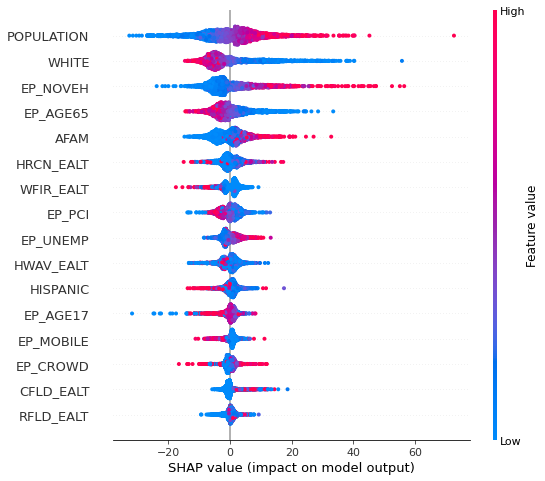

In [183]:
shap.plots.beeswarm(t_shap_values, max_display=20)

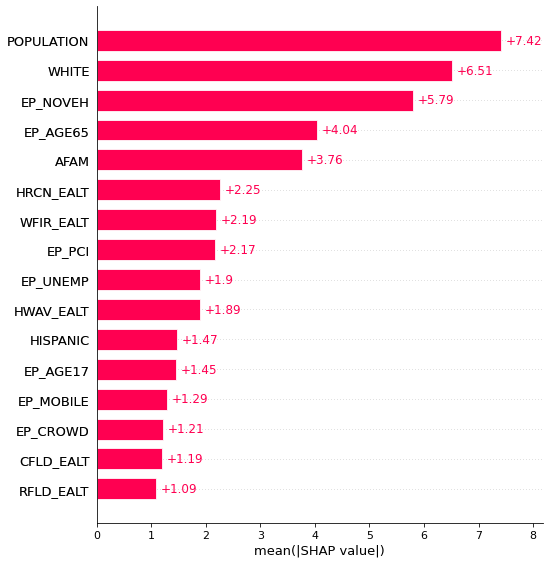

In [184]:
shap.plots.bar(t_shap_values, max_display=20)

### Dependence Plot: White (Mortgage Applicants) and Climate Disasters

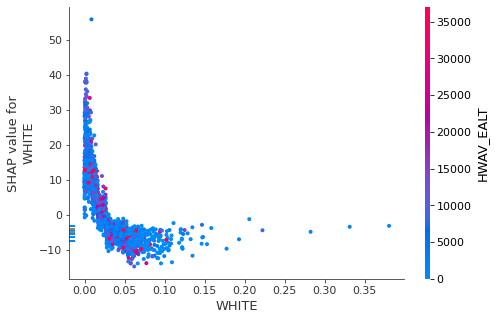

In [185]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HWAV_EALT")

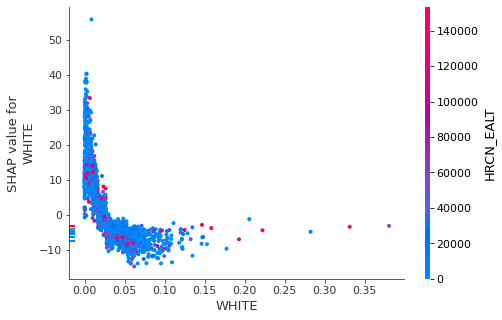

In [186]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="HRCN_EALT")

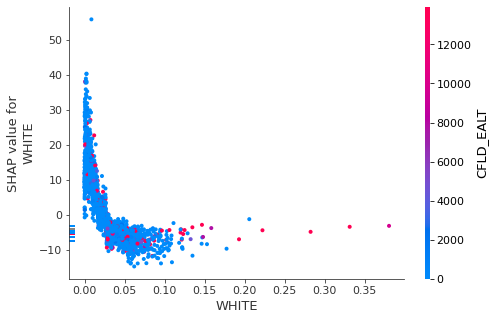

In [187]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="CFLD_EALT")

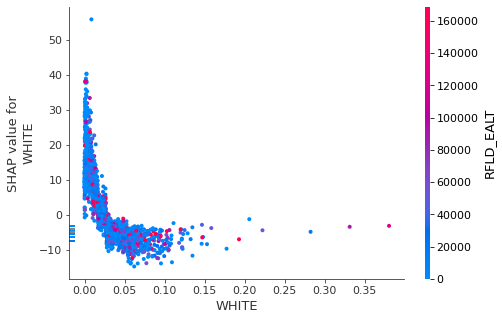

In [188]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="RFLD_EALT")

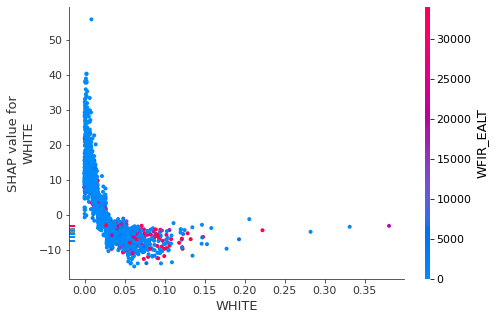

In [189]:
shap.dependence_plot("WHITE", shap_values, X_test, interaction_index="WFIR_EALT")

### Dependence Plot: No Vehicles and Climate Disasters

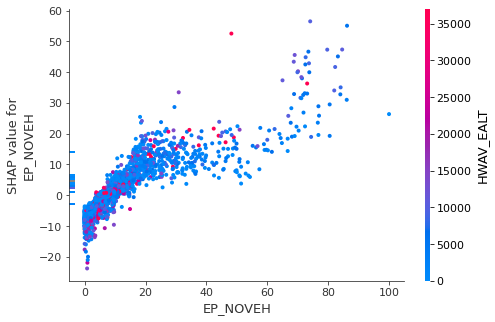

In [190]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HWAV_EALT")

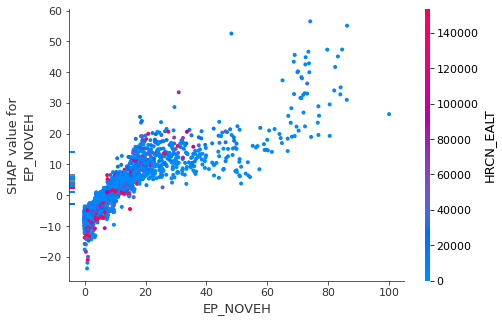

In [191]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="HRCN_EALT")

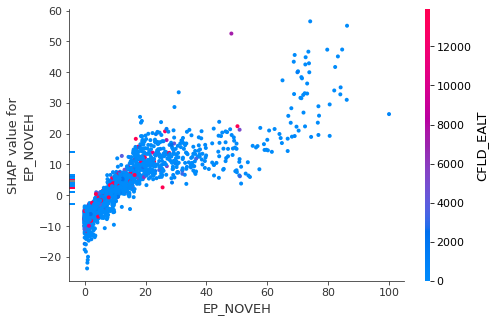

In [192]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="CFLD_EALT")

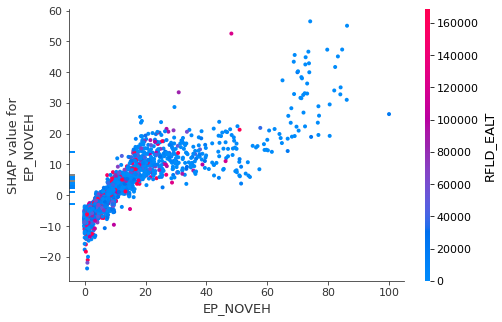

In [193]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="RFLD_EALT")

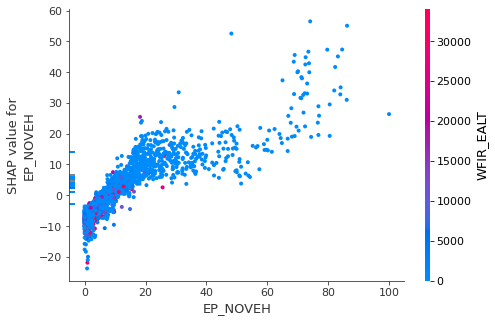

In [194]:
shap.dependence_plot("EP_NOVEH", shap_values, X_test, interaction_index="WFIR_EALT")

### Dependence Plot: African-American (Mortgage Applicants) and Climate Disasters

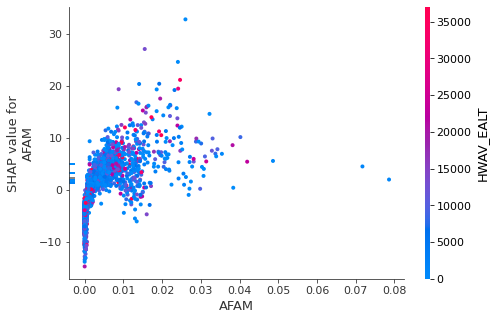

In [195]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HWAV_EALT")

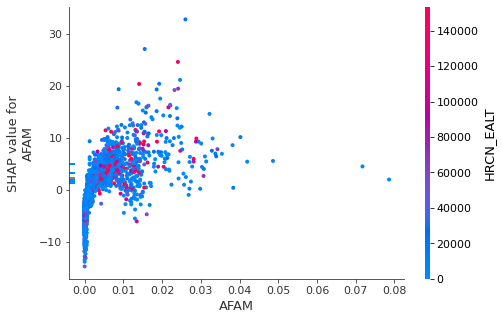

In [196]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="HRCN_EALT")

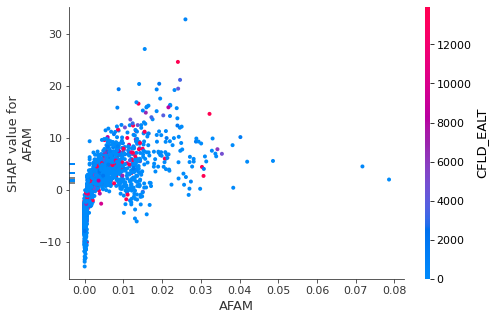

In [197]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="CFLD_EALT")

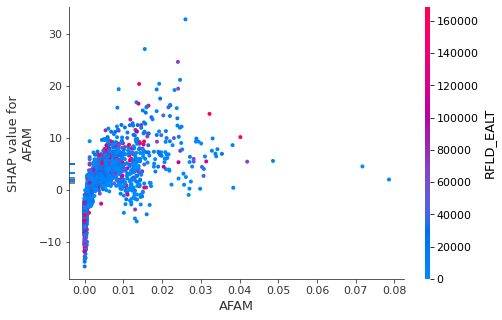

In [198]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="RFLD_EALT")

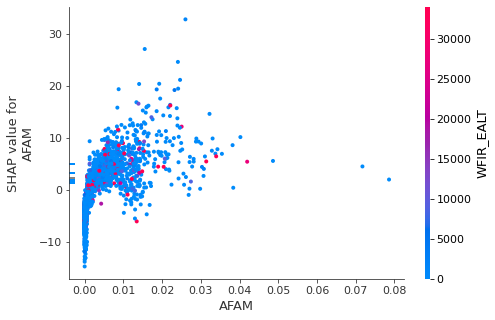

In [199]:
shap.dependence_plot("AFAM", shap_values, X_test, interaction_index="WFIR_EALT")

### Dependence Plot: Top Interaction for Each Feature

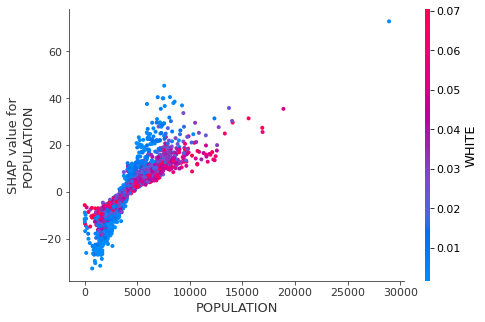

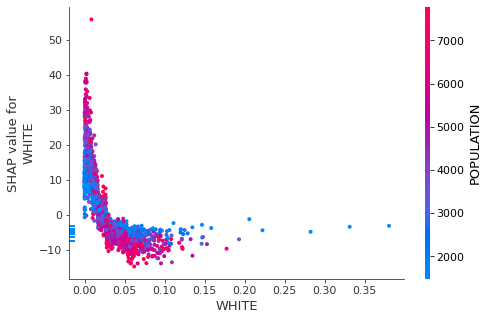

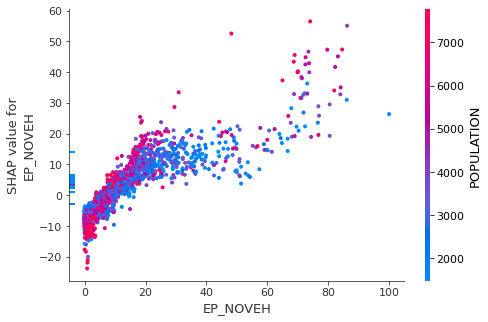

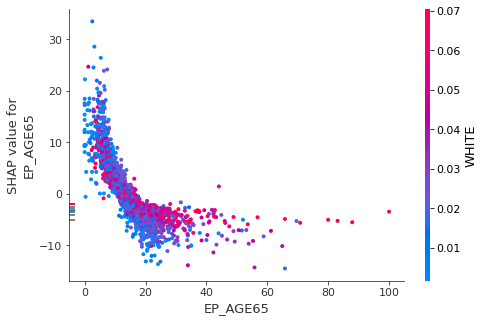

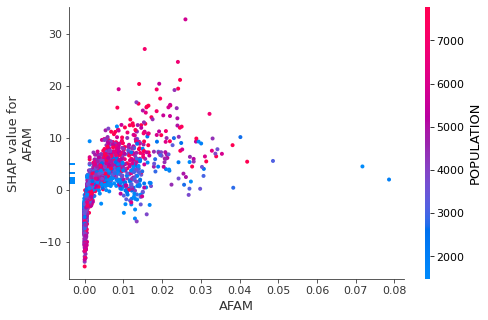

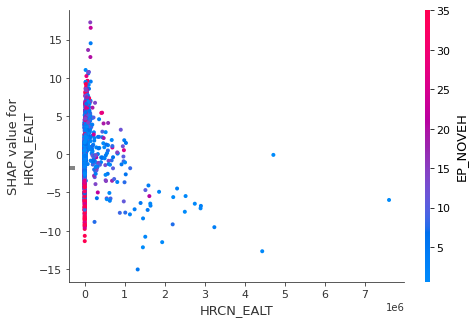

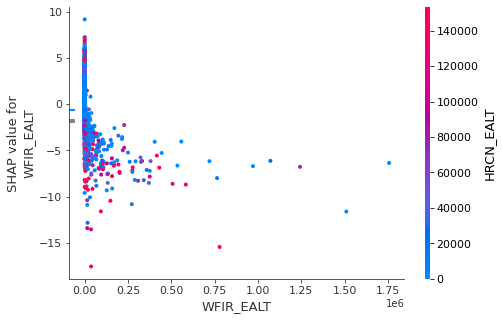

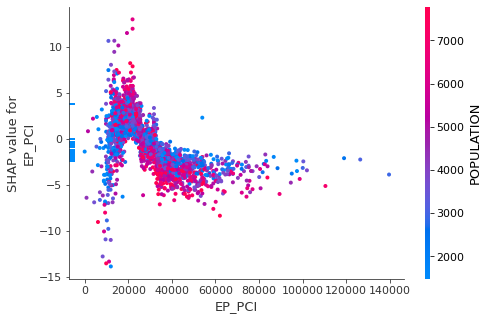

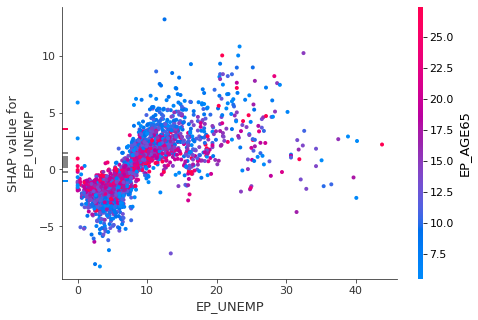

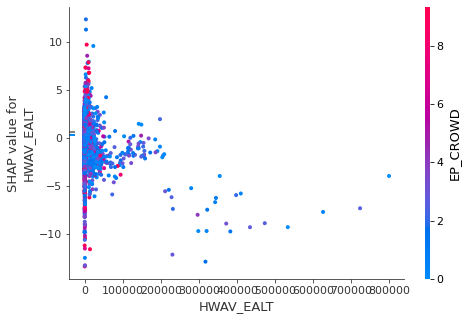

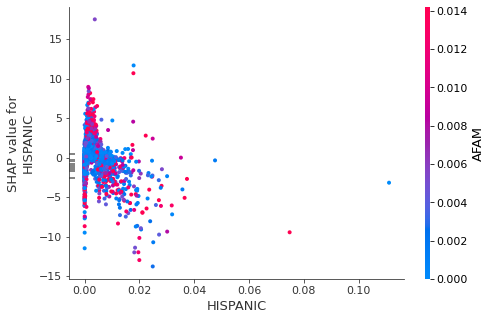

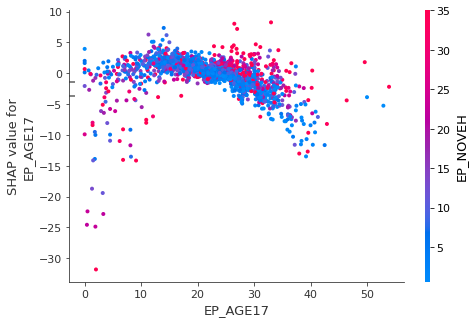

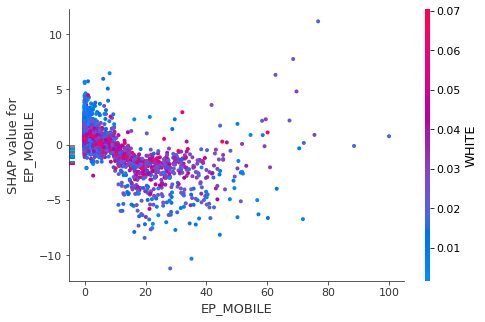

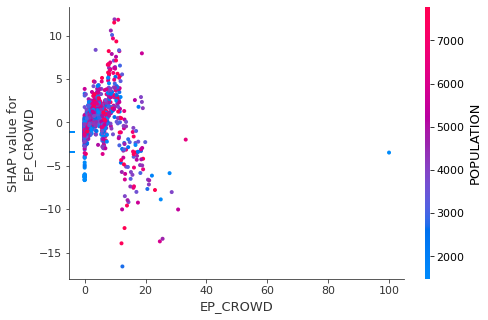

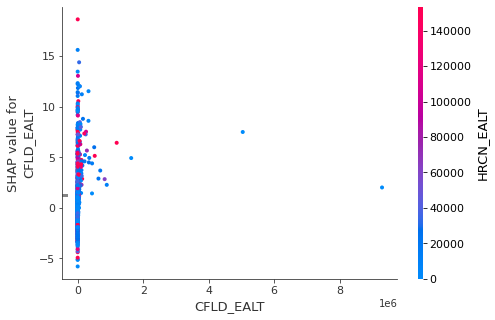

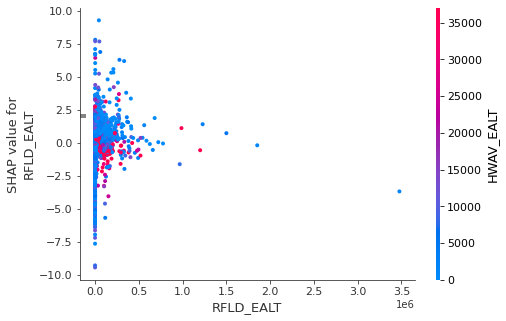

In [200]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(X_test.shape[1]):
    shap.dependence_plot(top_inds[i], shap_values, X_test)